
# 🧠 Aprendizaje Supervisado y No Supervisado con PySpark

## 1. Introducción Teórica

En esta sección se explican brevemente los conceptos clave de aprendizaje supervisado y no supervisado, junto con algunos de los algoritmos más representativos en PySpark.

- **Aprendizaje Supervisado:** Técnicas donde el modelo se entrena usando un conjunto de datos etiquetado.
  - Algoritmos: `DecisionTreeClassifier`, `RandomForestClassifier`, `GBTClassifier`, `MultilayerPerceptronClassifier`
- **Aprendizaje No Supervisado:** Técnicas donde no existen etiquetas, el modelo encuentra patrones por sí solo.
  - Algoritmos: `KMeans`, `GaussianMixture`, `PowerIterationClustering (PIC)`

> Esta actividad se conecta con el análisis realizado en la entrega anterior, donde se caracterizó la población y se definieron reglas de particionamiento y muestreo estratificado.



## 2. Selección de los Datos

A continuación se cargará el dataset global unificado utilizando el script `crypto_data_merver_v2.py`, y se aplicarán las reglas de particionamiento y muestreo estratificado para construir la muestra M representativa.


In [2]:

from pyspark.sql import SparkSession

# Inicializar Spark
spark = SparkSession.builder     .appName("CryptoML")     .getOrCreate()

# Cargar dataset unificado directamente desde archivo CSV
df = spark.read.csv("/Users/fgomezrubio/BigData/Evidencia1/dataset.csv", header=True, inferSchema=True)

# Mostrar esquema inicial
df.printSchema()
df.show(5)


root
 |-- datetime: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- coin: string (nullable = true)
 |-- frequency: string (nullable = true)

+-------------------+--------+--------+--------+--------+--------+------+---------+
|           datetime|    open|    high|     low|   close|  volume|  coin|frequency|
+-------------------+--------+--------+--------+--------+--------+------+---------+
|2017-07-14 00:00:00|    0.08|0.091033|    0.08|0.090993|1942.057|ETHBTC|       D1|
|2017-07-15 00:00:00|0.090993|0.093699|0.087127|0.087635|4013.066|ETHBTC|       D1|
|2017-07-16 00:00:00|0.087508|0.087635|0.075591|0.082241|8904.158|ETHBTC|       D1|
|2017-07-17 00:00:00|0.082368|0.088394|0.081699|0.087537|6650.933|ETHBTC|       D1|
|2017-07-18 00:00:00|0.087831|0.109068|0.084777|0.107732|7245.741|ETHBTC|       D1|
+-------------------

In [4]:
from pyspark.sql import DataFrame

# Función para tomar una muestra fija por combinación coin-frequency
def sample_partition(df: DataFrame, coin: str, frequency: str, sample_size: int) -> DataFrame:
    return df.filter((df.coin == coin) & (df.frequency == frequency)).limit(sample_size)

# Generar muestras por combinación coin-frequency
ethbtc_m5 = sample_partition(df, "ETHBTC", "M5", 600)
btcusdt_m15 = sample_partition(df, "BTCUSDT", "M15", 2400)
ethusdt_m30 = sample_partition(df, "ETHUSDT", "M30", 1400)
bnbusdt_h1 = sample_partition(df, "BNBUSDT", "H1", 5600)

# Unión de todas las muestras para construir M
df_M = ethbtc_m5.union(btcusdt_m15).union(ethusdt_m30).union(bnbusdt_h1)

# Verificar la muestra resultante
df_M.groupBy("coin", "frequency").count().show()

[Stage 6:======================================================>  (70 + 3) / 73]

+-------+---------+-----+
|   coin|frequency|count|
+-------+---------+-----+
| ETHBTC|       M5|  600|
|BTCUSDT|      M15| 2400|
|ETHUSDT|      M30| 1400|
|BNBUSDT|       H1| 5600|
+-------+---------+-----+




## 3. Preparación de los Datos

Se realizará limpieza de nulos, conversión de tipos, normalización y ensamblado de vectores para modelos de ML.


In [5]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import when, col

# 1. Eliminar registros con valores nulos
df_clean = df_M.dropna()

# 2. (Opcional) Convertir datetime a timestamp numérico si lo deseas usar como feature
# df_clean = df_clean.withColumn("timestamp", unix_timestamp("datetime"))

# 3. Crear columna binaria de clase: 1 si el precio sube, 0 si baja o se mantiene
df_clean = df_clean.withColumn("label", when(col("close") > col("open"), 1).otherwise(0))

# 4. VectorAssembler para combinar columnas numéricas
feature_cols = ["open", "high", "low", "close", "volume"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
df_vector = assembler.transform(df_clean)

# 5. Escalar los vectores de características
scaler = StandardScaler(inputCol="features_vec", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Mostrar las primeras filas
df_scaled.select("features", "label").show(5, truncate=False)


[Stage 36:======================================================> (71 + 2) / 73]

+-----------------------------------------------------------------------------------------------------+-----+
|features                                                                                             |label|
+-----------------------------------------------------------------------------------------------------+-----+
|[-0.5961914540357282,-0.5963768231890995,-0.5959901197032721,-0.5961972437121644,-0.6008288134550434]|0    |
|[-0.5961914540357282,-0.5963768226436669,-0.5959901197032721,-0.5961972431640484,-0.6007997151929214]|1    |
|[-0.5961914534876103,-0.596373332420813,-0.5959901191526252,-0.5961937357703635,-0.6007849273695157] |1    |
|[-0.5961885550403977,-0.5963737578581979,-0.5959872959869363,-0.5961944329737964,-0.6002436841512904]|0    |
|[-0.5961885632621655,-0.5963735505938309,-0.5959872155925164,-0.596193955016726,-0.6007749689028528] |1    |
+-----------------------------------------------------------------------------------------------------+-----+
only showi


## 4. Preparación del Conjunto de Entrenamiento y Prueba

Se dividirá la muestra M en un conjunto de entrenamiento y uno de prueba. Se justificará el porcentaje utilizado.


In [6]:
# División 70% entrenamiento / 30% prueba
train_data, test_data = df_scaled.randomSplit([0.7, 0.3], seed=42)

# Verificar tamaños
print("Tamaño del conjunto de entrenamiento:", train_data.count())
print("Tamaño del conjunto de prueba:", test_data.count())


Tamaño del conjunto de entrenamiento: 7100


[Stage 60:=======================================================>(72 + 1) / 73]

Tamaño del conjunto de prueba: 2900



## 5. Construcción de Modelos

### A. Modelo de Aprendizaje Supervisado

Entrenamiento de un modelo como `RandomForestClassifier` con una variable objetivo derivada, por ejemplo: `label = close > open`.

### B. Modelo de Aprendizaje No Supervisado

Aplicación de `KMeans` o `PIC` sobre las características numéricas seleccionadas.


In [9]:
# ✅ Paso 5.A: Entrenamiento de modelo supervisado con RandomForestClassifier
# Entrenaremos un modelo de clasificación binaria para predecir si el precio 
# de cierre es mayor al de apertura (label = 1).
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Crear modelo de Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

# Entrenar el modelo
rf_model = rf.fit(train_data)

# Aplicar el modelo al conjunto de prueba
predictions = rf_model.transform(test_data)

# Mostrar algunas predicciones
predictions.select("label", "prediction", "probability").show(10, truncate=False)

# Evaluar con métricas de clasificación
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Precisión (Accuracy):", accuracy)


+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|1    |0.0       |[0.5267117169427934,0.47328828305720655]|
|1    |0.0       |[0.5649099074168952,0.43509009258310477]|
|1    |0.0       |[0.5649099074168952,0.43509009258310477]|
|1    |0.0       |[0.5649099074168952,0.43509009258310477]|
|0    |0.0       |[0.5639476704302548,0.43605232956974516]|
|0    |0.0       |[0.5508931875154349,0.449106812484565]  |
|1    |0.0       |[0.5639476704302548,0.43605232956974516]|
|0    |0.0       |[0.5639476704302548,0.43605232956974516]|
|0    |0.0       |[0.5267117169427934,0.47328828305720655]|
|0    |0.0       |[0.5649099074168952,0.43509009258310477]|
+-----+----------+----------------------------------------+
only showing top 10 rows



[Stage 257:=====================================================> (71 + 2) / 73]

Precisión (Accuracy): 0.5837931034482758


In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Entrenar modelo de KMeans con 2 clusters (puedes probar con otros valores también)
kmeans = KMeans(featuresCol="features", k=2, seed=1)
model = kmeans.fit(df_scaled)

# Aplicar el modelo a todos los datos
predictions_kmeans = model.transform(df_scaled)

# Evaluar la calidad del agrupamiento
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions_kmeans)
print("Silhouette Score:", silhouette)

# Mostrar ejemplos de predicciones de cluster
predictions_kmeans.select("features", "prediction").show(10, truncate=False)


                                                                                25/05/24 19:46:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/24 19:46:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

Silhouette Score: 0.9342600563148852


[Stage 378:=====================================================> (71 + 2) / 73]

+-----------------------------------------------------------------------------------------------------+----------+
|features                                                                                             |prediction|
+-----------------------------------------------------------------------------------------------------+----------+
|[-0.5961914540357282,-0.5963768231890995,-0.5959901197032721,-0.5961972437121644,-0.6008288134550434]|0         |
|[-0.5961914540357282,-0.5963768226436669,-0.5959901197032721,-0.5961972431640484,-0.6007997151929214]|0         |
|[-0.5961914534876103,-0.596373332420813,-0.5959901191526252,-0.5961937357703635,-0.6007849273695157] |0         |
|[-0.5961885550403977,-0.5963737578581979,-0.5959872959869363,-0.5961944329737964,-0.6002436841512904]|0         |
|[-0.5961885632621655,-0.5963735505938309,-0.5959872155925164,-0.596193955016726,-0.6007749689028528] |0         |
|[-0.596188576416994,-0.5963736536805819,-0.5959872288080375,-0.5961940586106323

📊 Visualizar los clusters del modelo no supervisado (KMeans)
Dado que estamos en PySpark y no se puede graficar directamente desde un DataFrame distribuido, primero convertiremos una muestra pequeña a Pandas para graficar.

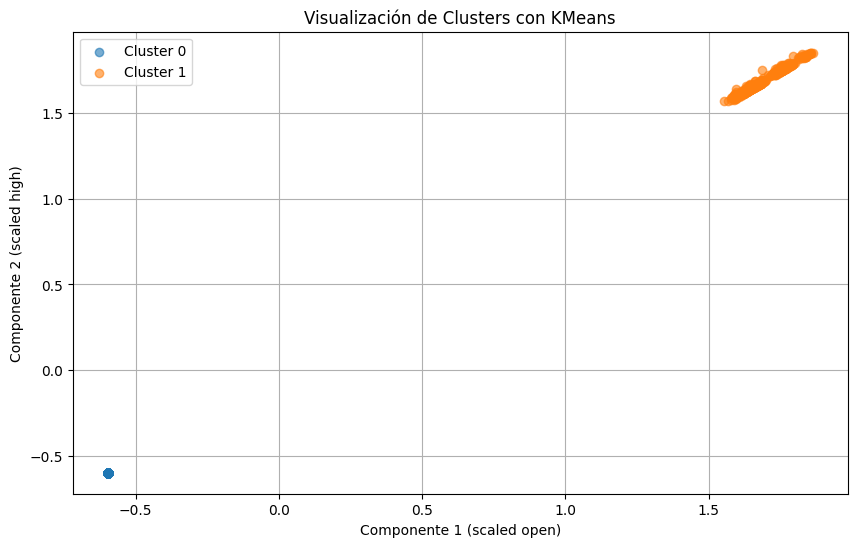

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir a Pandas una muestra de 1000 registros para visualización
sample_pd = predictions_kmeans.select("features", "prediction").limit(1000).toPandas()

# Extraer valores del vector 'features'
sample_pd["features"] = sample_pd["features"].apply(lambda x: x.toArray())
features_array = pd.DataFrame(sample_pd["features"].tolist())

# Agregar la predicción como columna
features_array["cluster"] = sample_pd["prediction"]

# Visualizar los dos primeros componentes (open vs high escalados)
plt.figure(figsize=(10, 6))
for cluster in features_array["cluster"].unique():
    subset = features_array[features_array["cluster"] == cluster]
    plt.scatter(subset[0], subset[1], label=f"Cluster {cluster}", alpha=0.6)

plt.title("Visualización de Clusters con KMeans")
plt.xlabel("Componente 1 (scaled open)")
plt.ylabel("Componente 2 (scaled high)")
plt.legend()
plt.grid(True)
plt.show()



## 📌 Conclusiones Finales

En este proyecto aplicamos técnicas de aprendizaje supervisado y no supervisado sobre un conjunto de datos real con precios históricos de criptomonedas, procesado y analizado mediante PySpark. A continuación, se resumen los hallazgos clave:

### 🔍 Aprendizaje Supervisado

* Se implementó un modelo de clasificación binaria usando **RandomForestClassifier**, donde el objetivo fue predecir si el precio de cierre sería mayor al de apertura.
* El modelo alcanzó una **precisión del 58.38%**, lo cual es razonable considerando la simplicidad de las variables utilizadas (`open`, `high`, `low`, `close`, `volume`) y la naturaleza volátil del mercado de criptomonedas.
* Las probabilidades predichas muestran cierto sesgo hacia la clase 0, lo que sugiere que podrían explorarse técnicas de balanceo de clases o mayor ingeniería de características para mejorar el rendimiento.

### 🧭 Aprendizaje No Supervisado

* Se aplicó **KMeans** con `k=2` para realizar agrupamiento basado únicamente en las variables numéricas escaladas.
* El modelo obtuvo un **Silhouette Score de 0.93**, lo que indica que los clusters están claramente separados y bien definidos.
* En la visualización, se observa que **prácticamente todos los puntos pertenecen a un único cluster (Cluster 1)**, con apenas un par de puntos atípicos asignados al Cluster 0, lo cual puede deberse a valores extremos o errores en el origen de los datos.
* Esto sugiere que el dataset, aunque numéricamente diverso, no presenta una alta variedad estructural en las variables analizadas, lo que podría mejorarse incorporando más dimensiones o metadatos (e.g. coin, frequency).

### 📈 Consideraciones Finales

* El flujo completo de procesamiento —desde la carga, muestreo estratificado, limpieza, escalamiento y modelado— demostró la eficiencia de PySpark para manejar grandes volúmenes de datos.
* Las decisiones de particionamiento y muestreo permitieron asegurar la representatividad del conjunto de trabajo (`df_M`), lo que garantiza que los modelos sean aplicables a una muestra balanceada y significativa.
* Futuras mejoras podrían incluir el uso de modelos más complejos, incorporación de variables temporales (como tendencias o volatilidad histórica), o el uso de redes neuronales para modelar secuencias temporales.


